In [20]:
% matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import readdy_learn.generate.generate_tools.kinetic_monte_carlo as kmc

In [21]:
system = kmc.ReactionDiffusionSystem(n_species=2, n_boxes=1, diffusivity=[[[0.]], [[0.]]], init_state=[[70, 0]], species_names=["A", "B"])
system.add_conversion("A", "B", np.array([4.]))
system.add_conversion("B", "A", np.array([0.5]))
system.simulate(300)
time_series, times = system.convert_events_to_time_series(n_frames=1000)

[KMC] [2017-10-11 11:08:44] [INFO] Simulate for 300 steps


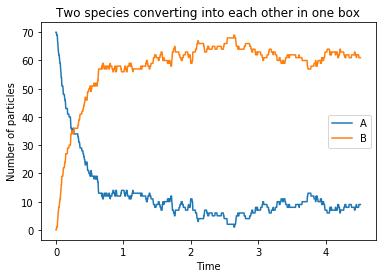

In [22]:
plt.plot(times, time_series[:,0,0], label="A")
plt.plot(times, time_series[:,0,1], label="B")
plt.legend(loc="best")
plt.xlabel("Time")
plt.ylabel("Number of particles")
plt.title("Two species converting into each other in one box")
plt.show()

In [23]:
import readdy_learn.analyze.tools as pat

In [24]:
def get_counts_config(system, n_frames):
    counts, times = system.convert_events_to_time_series(n_frames=n_frames)
    # flatten out spatial dimension and convert to float
    counts = np.sum(counts, axis=1, dtype=np.float64)
    config = system.get_trajectory_config()
    return counts, times, config

In [44]:
counts, times, config = get_counts_config(system, 500) 
traj = pat.Trajectory.from_counts(config, counts, times[1]-times[0])
traj.update()

max counts = 70.0, min nonzero counts = 1.0


In [38]:
from readdy_learn.analyze.sklearn import BasisFunctionConfiguration

bfc = BasisFunctionConfiguration(n_species=traj.n_species)
bfc.add_conversion(0, 1) # A -> B
bfc.add_conversion(1, 0) # B -> A
right_rates = np.array([config.reactions[0].rate, config.reactions[1].rate]).squeeze()

In [39]:
from readdy_learn.analyze.sklearn import ReaDDyElasticNetEstimator

est = ReaDDyElasticNetEstimator(traj, bfc, 1., 
                                alpha=0., l1_ratio=1., method=None,
                                verbose=True, approx_jac=False, options={'ftol': 1e-15})
est.fit(None)
coefficients = est.coefficients_
print("coefficients: {}".format(coefficients))
print("right rates: {}".format(right_rates))

optimization problem did exit successfully (alpha=0.0, lambda=1.0)!
status 0: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
18 / 15000 iterations
coefficients: [ 0.0219805   0.10374712  3.13548927  0.10374712]
right rates: [ 4.   0.5]


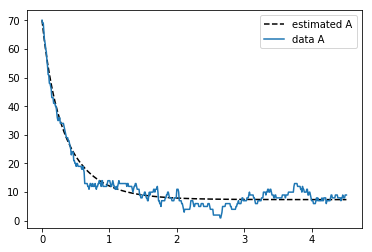

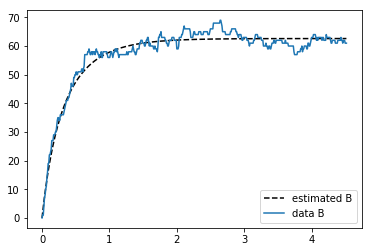

In [40]:
from scipy.integrate import odeint


def fun(data, _):
    theta = np.array([f(data) for f in bfc.functions])
    return np.matmul(coefficients, theta)


estimated_realisation = odeint(fun, traj.counts[0], np.arange(0., traj.n_time_steps * traj.time_step, traj.time_step))
for t in config.types.keys():
    type_id = config.types[t]
    plt.plot(times, estimated_realisation[:, type_id], "k--", label="estimated " + t)
    plt.plot(times, traj.counts[:, type_id], label="data " + t)
    plt.legend(loc="best")
    plt.show()
